In [2]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")
print("Path to dataset files:", path)

100%|██████████| 656M/656M [00:07<00:00, 87.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5


In [162]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [163]:
# ensuring the GPU is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print('GPU is available')
else:
  print('GPU is not being used.')

GPU is not being used.


In [164]:
dataset_path = "/root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/animals/animals"
classes=os.listdir(dataset_path)
num_classes = len(classes)
print(f'number of classes: {num_classes}')
print(f'classes: {classes}')

number of classes: 90
classes: ['coyote', 'orangutan', 'caterpillar', 'dog', 'reindeer', 'turkey', 'grasshopper', 'ladybugs', 'sandpiper', 'deer', 'chimpanzee', 'possum', 'goose', 'rat', 'hare', 'dragonfly', 'cat', 'lion', 'wolf', 'fox', 'gorilla', 'owl', 'horse', 'antelope', 'hummingbird', 'porcupine', 'snake', 'tiger', 'hippopotamus', 'eagle', 'koala', 'badger', 'pelecaniformes', 'bee', 'otter', 'sheep', 'raccoon', 'dolphin', 'butterfly', 'starfish', 'moth', 'flamingo', 'turtle', 'cockroach', 'sparrow', 'panda', 'duck', 'boar', 'shark', 'squirrel', 'woodpecker', 'seahorse', 'crab', 'rhinoceros', 'elephant', 'hyena', 'bison', 'octopus', 'okapi', 'lizard', 'donkey', 'goldfish', 'crow', 'whale', 'lobster', 'hamster', 'penguin', 'bear', 'parrot', 'zebra', 'fly', 'wombat', 'pigeon', 'cow', 'mouse', 'squid', 'swan', 'goat', 'hornbill', 'jellyfish', 'bat', 'oyster', 'pig', 'mosquito', 'ox', 'hedgehog', 'leopard', 'kangaroo', 'beetle', 'seal']


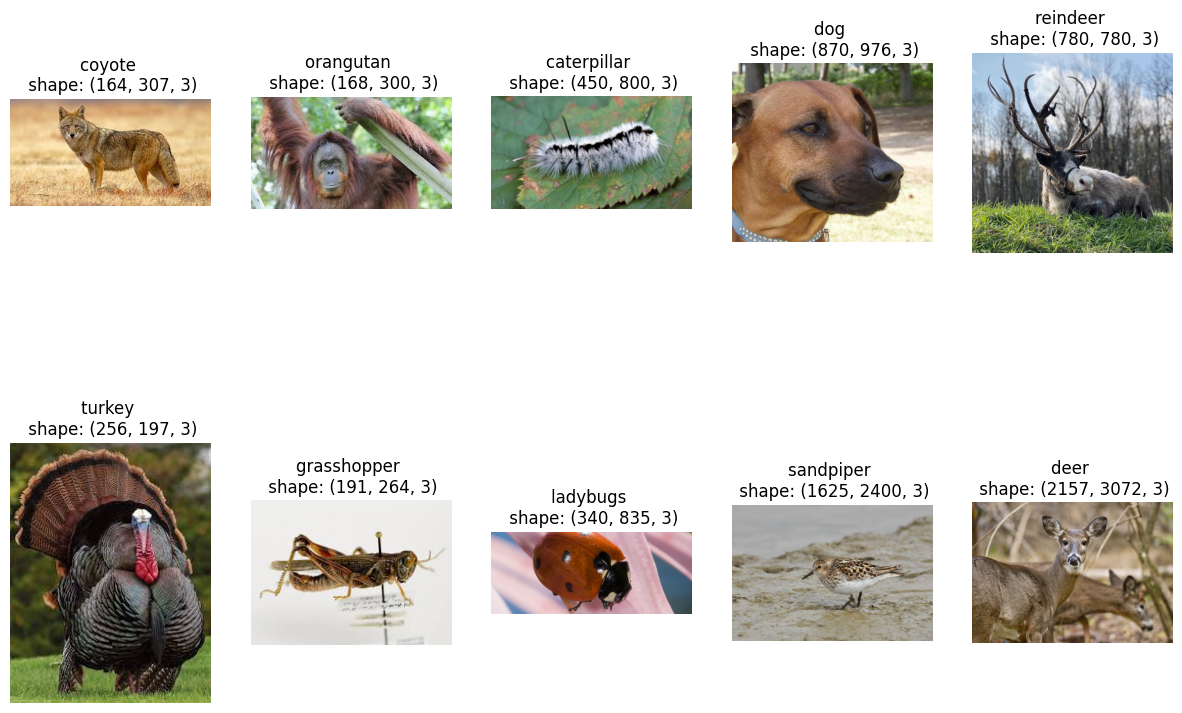

In [165]:
plt.figure(figsize=(15,10))
for i, class_name in enumerate(classes[:10]):
  class_path = os.path.join(dataset_path, class_name)
  image_name = os.listdir(class_path)[0]
  image_path = os.path.join(class_path, image_name)
  image = plt.imread(image_path)

  plt.subplot(2, 5, i+1)
  plt.imshow(image)
  plt.title(f'{class_name} \n shape: {image.shape}')
  plt.axis('off')
  plt.tight_layout

In [191]:
image_size = (224, 224)
batch_size = 64


datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.1
)


train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [167]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print("class_names:", class_names)

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [194]:
#Load MobileNetV2 as the base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# Freeze the base model weights, training
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation= 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # output layer

# Create the final model
model = Model(inputs=base_model.input,outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
model.summary()


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_38[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [196]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples  // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples  // batch_size,
    epochs=20
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.7939 - loss: 0.9065 - val_accuracy: 0.8320 - val_loss: 0.7721
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 339ms/step - accuracy: 0.8750 - loss: 0.6340 - val_accuracy: 0.8301 - val_loss: 0.7494
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 322s 4s/step - accuracy: 0.8379 - loss: 0.7125 - val_accuracy: 0.8379 - val_loss: 0.7131
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 537ms/step - accuracy: 0.7969 - loss: 0.8085 - val_accuracy: 0.8340 - val_loss: 0.7148
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.8459 - loss: 0.6128 - val_accuracy: 0.8438 - val_loss: 0.6498
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 329ms/step - accuracy: 0.8594 - loss: 0.5307 - val_accuracy: 0.8320 - val_loss: 0.6889
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.8805 - loss: 0.5337 - val_accuracy: 0.8457 - val_loss: 0.6431
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - accuracy: 0.9375 - loss: 0.4200 - val_accuracy: 0.

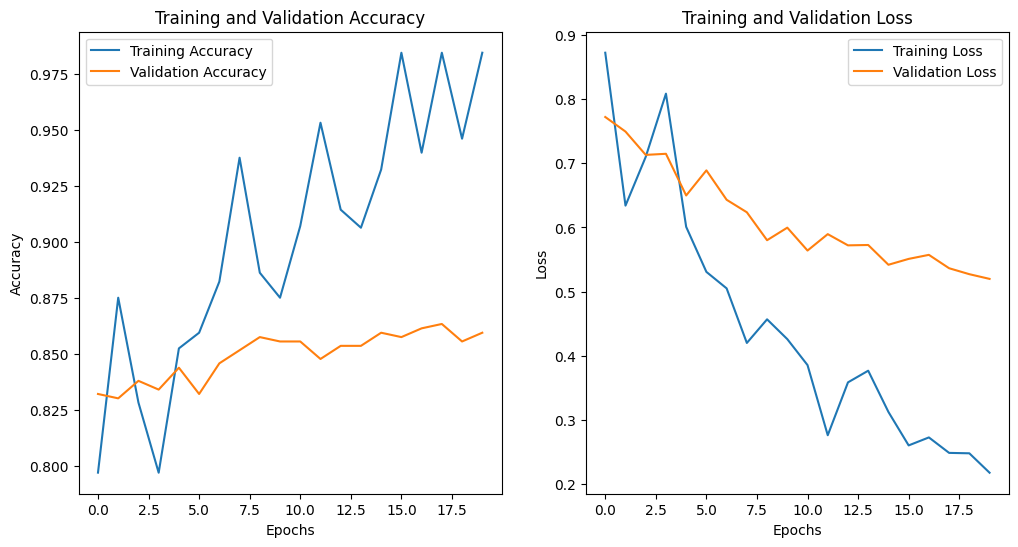

In [205]:
#Evaluate the model - plotting the training and validation acc/loss
plt.figure(figsize=(12, 6))

plt. subplot (1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend ()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend ()

plt.show()

In [206]:
value_loss, value_accuracy = model.evaluate(validation_generator)
print(f'validation Loss: {value_loss}')
print(f'validation Accuracy: {value_accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8598 - loss: 0.5139
validation Loss: 0.5254877805709839
validation Accuracy: 0.8574073910713196


In [207]:
#save the model
model.save('MCAR.keras')

In [232]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

model = load_model('MCAR.keras')

def predict_animal(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    image_array = image.img_to_array(img)
    image_array = np.expand_dims(image_array, axis=0)
    image_array /=255.0

    prediction = model.predict(image_array)
    predicted_class = class_names[np.argmax(prediction)]
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

In [233]:
os.listdir('/root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/animals/animals/parrot')

['34f9668c8e.jpg',
 '036b760476.jpg',
 '64c08f053c.jpg',
 '7b8d54f49e.jpg',
 '1dd93e1004.jpg',
 '6a184a05f3.jpg',
 '46de4406fb.jpg',
 '2f207b75e3.jpg',
 '46c1b71d00.jpg',
 '3f5e9e225b.jpg',
 '89d679b9e5.jpg',
 '4ead913624.jpg',
 '1b9f359f9c.jpg',
 '62fc818264.jpg',
 '9d0d266d23.jpg',
 '87bc6bdcd7.jpg',
 '7a7fdb0450.jpg',
 '5d18e7e995.jpg',
 '27a9ce4e1a.jpg',
 '7d5cb5f5fa.jpg',
 '4c26cd72e2.jpg',
 '6be2eb3fb3.jpg',
 '9c2dd51734.jpg',
 '96c5e35a54.jpg',
 '3ac69be3f6.jpg',
 '60e0c50a4a.jpg',
 '8cdc657d99.jpg',
 '4aba5914cd.jpg',
 '6a0ab0de34.jpg',
 '1cabf8a760.jpg',
 '66e79b1a2f.jpg',
 '84b6622dbc.jpg',
 '7dab3a1142.jpg',
 '0100ec7408.jpg',
 '47d00fc79f.jpg',
 '56b19e9dbc.jpg',
 '080a286cf3.jpg',
 '3a0c5d4582.jpg',
 '5affc48d37.jpg',
 '0b29c10342.jpg',
 '8a8a69d934.jpg',
 '50e40b5356.jpg',
 '4faf55514e.jpg',
 '4af25ae32d.jpg',
 '61def3553e.jpg',
 '91f0604cc7.jpg',
 '060cca8826.jpg',
 '5b1030ddd5.jpg',
 '1f4f736dbf.jpg',
 '29c26708a0.jpg',
 '8f5a2730b3.jpg',
 '0b2a1e349a.jpg',
 '3de507dbb6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


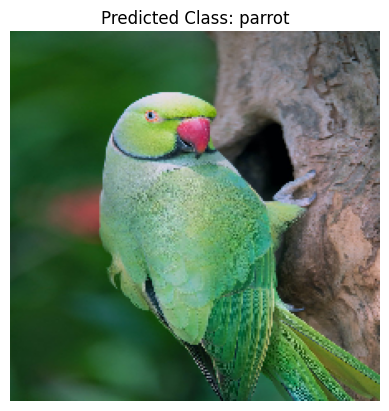

In [236]:
predict_animal('/root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/animals/animals/parrot/91f0604cc7.jpg')